# Q1

## getting the data

In [16]:
import kagglehub
import shutil
import os

path=kagglehub.dataset_download("mohamad1dehqani/persian-spam-email")

In [36]:
import pandas as pd

raw_data=pd.read_csv('./data/emails.csv')

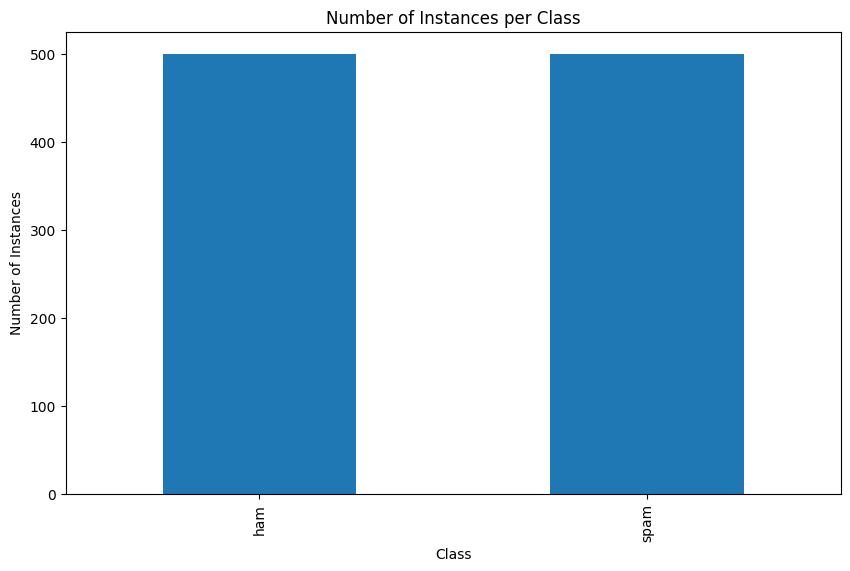

In [37]:
import matplotlib.pyplot as plt

class_counts = raw_data['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Class')
plt.show()


## preprocess

In [38]:
raw_data['text']

0      ﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...
1      ﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...
2      ﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...
3      ﻿با سلام  و احترام\nضمن تقدیر از مسولین محترم ...
4      ﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...
                             ...                        
995    ﻿\nبسمه تعالی\n\nسازمان زیباسازی شهرداری استان...
996    ﻿\n\nبه مناسبت فرا رسیدن میلاد دخت پیامبر گرام...
997    ﻿\nدرود هموطن من\n\n \n\nتست رایگان   \n\n    ...
998    ﻿\n\n    *درج **لینک  در 8700 وبلاگ\n    *\n\n...
999    ﻿\nسلام به دوستان عزیز\nشما هم میتوانید از این...
Name: text, Length: 1000, dtype: object

In [39]:
import pandas as pd
import re

url_pattern = r'http[s]?://\S+|www\.\S+|WWW\.\S+|Www\.\S+|WwW\.\S+'
email_pattern = r'\b[A-Za-z0-9\*._%+-]+@[A-Za-z0-9\*.-]+\.[A-Z|a-z]{2,}\b'
phone_pattern = r'\d{11}|(\d{4}[ -\*]\d{3}[ -\*]\d{4})|\d{3}[-]+\d{8}|\d{3}[ ]+\d{8}|[(]\d{3}[) ]+\d{8}|\d{8}'
combined_pattern = f'({url_pattern})|({email_pattern})|({phone_pattern})'

def clean_text(text):
    cleaned_text = re.sub(r'(.)\1+', r'\1', text)
    return re.sub(combined_pattern, '', cleaned_text)


raw_data['text'] = raw_data['text'].apply(clean_text)

raw_data.to_csv('./data/cleaned_dataset.csv', index=False)

In [40]:
with open('./data/persian_stopwords', 'r', encoding='utf-8') as f:
    persian_stop_words = f.read().splitlines()

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in persian_stop_words]
    return ' '.join(filtered_words)

raw_data['text'] = raw_data['text'].apply(remove_stopwords)
raw_data.to_csv('./data/cleaned_dataset.csv', index=False)

## tokenizing

In [43]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model.hidden_size=120
texts = raw_data['text'].tolist()
inputs = tokenizer(texts, padding='max_length', max_length=32, return_tensors="pt", truncation=True)

with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs.last_hidden_state
sentence_vectors = hidden_states.mean(dim=1).numpy()

In [50]:
import torch
from sklearn.decomposition import PCA

flattened_tensor = hidden_states.view(-1, 768).numpy()

pca = PCA(n_components=120)
reduced_tensor = pca.fit_transform(flattened_tensor)

vectorized_data = torch.tensor(reduced_tensor).view(1000, 32, 120)

print(vectorized_data.shape)


torch.Size([1000, 32, 120])


## Preparing Data for Training

In [52]:
labels = raw_data['label'].values.copy()
for i in range(len(labels)):
    if labels[i]=='ham':
        labels[i]=0
    else:
        labels[i]=1

In [53]:
import numpy as np
sequence_length = 1
num_samples = vectorized_data.shape[0]
num_features = vectorized_data.shape[1]

num_sequences = num_samples // sequence_length

# data_reshaped = vectorized_data[:num_sequences * sequence_length].to_numpy().reshape(num_sequences, sequence_length, num_features)

labels_reshaped = labels[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
labels_reshaped = labels_reshaped[:, -1] 

print(vectorized_data.shape)
print(labels_reshaped.shape)

torch.Size([1000, 32, 120])
(1000,)


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_data, labels_reshaped, test_size=0.3, random_state=42)

In [55]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [84]:
X_train.shape

torch.Size([700, 32, 120])

## Grid Search

In [118]:
import itertools
import tensorflow as tf

batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
optimizers = {'Adam': tf.keras.optimizers.Adam, 'SGD': tf.keras.optimizers.SGD}

def grid_search(creator_func):
    best_accuracy = 0
    best_params = {}
    results = []

    for batch_size, learning_rate, (opt_name, optimizer) in itertools.product(batch_sizes, learning_rates, optimizers.items()):
        model = creator_func(optimizer, learning_rate)
        
        history = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=5,
                            verbose=0)
        
        final_accuracy = history.history['accuracy'][-1]
        results.append((batch_size, learning_rate, opt_name, final_accuracy))
        
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'optimizer': opt_name}

    print("best params:")
    print(best_params)


## Training CNN LSTM:

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM

def create_cnn_lstm(optimizer, learning_rate):
    cnn_lstm_model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, dropout=0.2),
        Dense(1, activation='sigmoid')
    ])

    model_optimizer = optimizer(learning_rate=learning_rate)
    cnn_lstm_model.build(input_shape=(None, 32, 120))
    cnn_lstm_model.compile(optimizer=model_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_lstm_model

In [119]:
grid_search(create_cnn_lstm)

best params:
{'batch_size': 8, 'learning_rate': 0.001, 'optimizer': 'Adam'}


In [125]:
cnn_lstm_model=create_cnn_lstm(optimizers['Adam'], 0.001)
cnn_lstm_model.summary()

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)              │ (None, 30, 32)         │        11,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_46 (MaxPooling1D) │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,449 (142.38 KB)

 Trainable params: 36,449 (142.38 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_train[:len(X_train)//5], y_train[:len(y_train)//5]))

loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6356 - loss: 0.6327 - val_accuracy: 0.9286 - val_loss: 0.2474
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9362 - loss: 0.2480 - val_accuracy: 0.9571 - val_loss: 0.1435
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9615 - loss: 0.1172 - val_accuracy: 0.9643 - val_loss: 0.0931
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9887 - loss: 0.0542 - val_accuracy: 0.9857 - val_loss: 0.0589
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9867 - loss: 0.0581 - val_accuracy: 0.9857 - val_loss: 0.0487
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9819 - loss: 0.0352 - val_accuracy: 0.9929 - val_loss: 0.0395
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9971 - loss: 0.0180 - val_accuracy: 0.9929 - val_loss: 0.0121
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9832 - loss: 0.0393 - val_accuracy: 0.9929 - val_los

## Training CNN:

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

cnn_model = Sequential([
    # Embedding(input_dim=6000, output_dim=64,embeddings_initializer='uniform'),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

cnn_model.build(input_shape=(None, 32, 120))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 30, 32)         │        11,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_train[:len(X_train)//5], y_train[:len(y_train)//5]))

loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6450 - loss: 0.6999 - val_accuracy: 0.9500 - val_loss: 0.2311
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9578 - loss: 0.1355 - val_accuracy: 0.9714 - val_loss: 0.0957
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9907 - loss: 0.0502 - val_accuracy: 0.9857 - val_loss: 0.0417
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9953 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0209
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 0.0145
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss

## Training LSTM

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout

lstm_model = Sequential([
    LSTM(64, dropout=0.2, stateful=False, kernel_initializer='glorot_uniform'),
    Dense(1, activation='sigmoid')
])

lstm_model.build(input_shape=(None, 32, 120))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        47,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,425 (185.25 KB)

 Trainable params: 47,425 (185.25 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6695 - loss: 0.6014 - val_accuracy: 0.9571 - val_loss: 0.2748
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9206 - loss: 0.2760 - val_accuracy: 0.9714 - val_loss: 0.1290
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9477 - loss: 0.1509 - val_accuracy: 0.9714 - val_loss: 0.1176
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9675 - loss: 0.0966 - val_accuracy: 0.9714 - val_loss: 0.1157
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9814 - loss: 0.0615 - val_accuracy: 0.9714 - val_loss: 0.1142
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.0501 - val_accuracy: 0.9714 - val_loss: 0.1516
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9888 - loss: 0.0360 - val_accuracy: 0.9643 - val_loss: 0.1606
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9957 - loss: 0.0145 - val_accuracy: 0.9714 - val_loss

## Eval:

In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_metrics(model):
    y_pred = model.predict(X_test) > 0.5

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


In [99]:
print("LSTM:")
get_metrics(lstm_model)
print("CNN:")
get_metrics(cnn_model)
print("CNN_LSTM:")
get_metrics(cnn_lstm_model)

LSTM:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.9700
Precision: 0.9732
Recall: 0.9667
F1-Score: 0.9699
ROC AUC: 0.9700
CNN:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.9467
Precision: 0.9408
Recall: 0.9533
F1-Score: 0.9470
ROC AUC: 0.9467
CNN_LSTM:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.9767
Precision: 0.9735
Recall: 0.9800
F1-Score: 0.9767
ROC AUC: 0.9767
